In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mglearn
import graphviz
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv("Ecolicounts.csv")
df.head()

,PId,Village/Farm/Marketno,Studysite,Status,Sampletype,Sample1or2,Season,Uniqueid,TBXcount,StatusTBX,...,NDM1,pH,Conductivity,Temp,GISND,GISNM,GISED,GISEM,GISlat,GISlong
0,TR001,1,Rural household,High exposure,Compound soil,1,Winter,11211TR001,0,Negative,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TR001,1,Rural household,High exposure,Drinking water,1,Winter,11311TR001,0,Negative,...,0.00,7.4,173.0,25.4,NaN,NaN,NaN,NaN,NaN,NaN
2,TR001,1,Rural household,High exposure,Waste water,1,Winter,11411TR001,220000,Positive,...,174999.38,7.7,202.0,22.7,NaN,NaN,NaN,NaN,NaN,NaN
3,TR001,1,Rural household,High exposure,Downstream river water,1,Winter,11611TR001,217,Positive,...,0.00,7.6,262.0,22.7,24.0,5.384,90.0,6.273,24.08973,90.10455
4,TR001,1,Rural household,High exposure,Poultry pens,1,Winter,11811TR001,22000000,Positive,...,101832.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#subset non water samples to deal with NAs

non_water_data = df[~df['Sampletype'].isin(['Downstream river water',
                                       'Downstream pond water', 
                                       'Poultry drinking water', 
                                       'Waste water', 
                                       'Waste water-2',
                                           'Drinking water'])].copy()

non_water_data.head()

,PId,Village/Farm/Marketno,Studysite,Status,Sampletype,Sample1or2,Season,Uniqueid,TBXcount,StatusTBX,...,NDM1,pH,Conductivity,Temp,GISND,GISNM,GISED,GISEM,GISlat,GISlong
0,TR001,1,Rural household,High exposure,Compound soil,1,Winter,11211TR001,0,Negative,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TR001,1,Rural household,High exposure,Poultry pens,1,Winter,11811TR001,22000000,Positive,...,101832.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TR001,1,Rural household,High exposure,Poultry caecal sample,1,Winter,11911TR001,22000000,Positive,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TR001,1,Rural household,High exposure,Human faeces,1,Winter,111011TR001,3600000,Positive,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TR001,1,Rural household,High exposure,Poultry caecal sample-2,2,Winter,111911TR001,22000000,Positive,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#split data 80/20
non_water_data = pd.get_dummies(non_water_data, columns=['StatusESBL'])
X_train, X_test, y_train, y_test = train_test_split(non_water_data.drop('StatusESBL_Positive', axis = 1), non_water_data['StatusESBL_Positive'],
                                                    random_state=0)

In [7]:
#consolidate cleaning steps and do them to training and test sets separately
#drop unnecessary columns
X_train = X_train.drop(['PId', 'Village/Farm/Marketno',
       'Sample1or2','Uniqueid', 'TBXcount', 'StatusTBX',
       'ESBLcount','KPCcount','GISND', 'GISNM', 'GISED', 'GISEM', 'GISlat',
       'GISlong'], axis = 1)


#interpolate NA values
X_train = X_train.interpolate(method='linear')


#get dummies for categorical variables
X_train = pd.get_dummies(X_train, columns=['Studysite', 'Status', 'Sampletype', 'Season', 'StatusK', ])


#drop out redundant dummy columns
X_train = X_train.drop(['Status_Low exposure', 'Season_Winter', 'StatusESBL_Negative', 'StatusK_Negative'], axis = 1)


X_train.head()

,CTXM,NDM1,pH,Conductivity,Temp,Studysite_Live bird market,Studysite_Poultry farm,Studysite_Rural household,Status_High exposure,Sampletype_Animal manure,...,Sampletype_Poultry Poultry caecal sample-2,Sampletype_Poultry caecal sample,Sampletype_Poultry caecal sample-2,Sampletype_Poultry pens,Sampletype_Poultry pens-2,Sampletype_River sediment,Sampletype_Solid waste,Sampletype_Solid waste-2,Season_Summer,StatusK_Positive
769,2.380000e+09,0.0,NaN,NaN,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
577,4.383992e+05,0.0,NaN,NaN,NaN,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
915,0.000000e+00,0.0,NaN,NaN,NaN,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
154,0.000000e+00,0.0,NaN,NaN,NaN,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
768,1.400000e+06,0.0,NaN,NaN,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
#same process for X_test
#consolidate cleaning steps and do them to training and test sets separately
#drop unnecessary columns
X_test = X_test.drop(['PId', 'Village/Farm/Marketno',
       'Sample1or2','Uniqueid', 'TBXcount', 'StatusTBX',
       'ESBLcount','KPCcount','GISND', 'GISNM', 'GISED', 'GISEM', 'GISlat',
       'GISlong'], axis = 1)


#interpolate NA values
X_test = X_test.interpolate(method='linear')


#get dummies for categorical variables
X_test = pd.get_dummies(X_test, columns=['Studysite', 'Status', 'Sampletype', 'Season', 'StatusK', ])


#drop out redundant dummy columns
X_test = X_test.drop(['Status_Low exposure', 'Season_Winter', 'StatusESBL_Negative', 'StatusK_Negative'], axis = 1)


X_test.head()

,CTXM,NDM1,pH,Conductivity,Temp,Studysite_Live bird market,Studysite_Poultry farm,Studysite_Rural household,Status_High exposure,Sampletype_Animal manure,...,Sampletype_Human faeces-2,Sampletype_Poultry Poultry caecal sample,Sampletype_Poultry caecal sample,Sampletype_Poultry caecal sample-2,Sampletype_Poultry pens,Sampletype_Poultry pens-2,Sampletype_Solid waste,Sampletype_Solid waste-2,Season_Summer,StatusK_Positive
375,0.000000e+00,0.0,NaN,NaN,NaN,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
364,1.220266e+08,0.0,NaN,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,3.185413e+05,0.0,NaN,NaN,NaN,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
56,0.000000e+00,0.0,NaN,NaN,NaN,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
647,3.048236e+08,0.0,NaN,NaN,NaN,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [9]:
# Preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier()
}

#hyperparameter tuning
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'] 
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 150, 200, 250], 
        'classifier__max_depth': [5, 10, 20, 30, None]  
    },
    'GradientBoosting': {
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
        'classifier__n_estimators': [50, 100, 150, 200, 250] 
    }
}


best_models = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[model_name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

# Print best models
for model_name, model in best_models.items():
    print(f"Best {model_name}: {model}")



/Users/ellieblaschko/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/ellieblaschko/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ellieblaschko/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/ellieblaschko/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ellieblaschko/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarnin

Best LogisticRegression: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CTXM', 'NDM1', 'pH', 'Conductivity', 'Temp'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
    

LogisticRegression AUROC: 0.6702279202279203
RandomForest AUROC: 0.6292411292411292
GradientBoosting AUROC: 0.5878010878010878


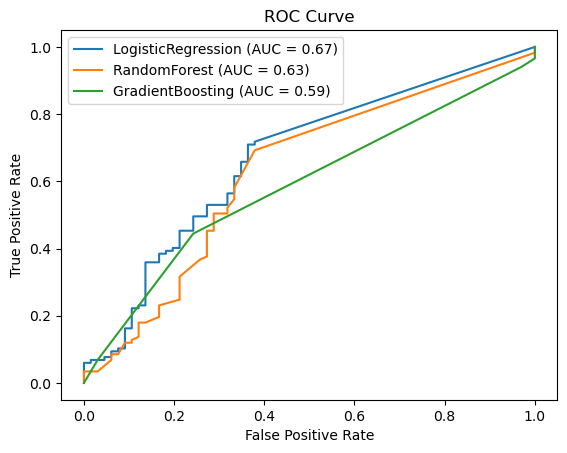

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

for model_name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} AUROC: {auc}")
    
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

LogisticRegression AUROC: 0.6702279202279203
RandomForest AUROC: 0.6292411292411292
GradientBoosting AUROC: 0.5878010878010878


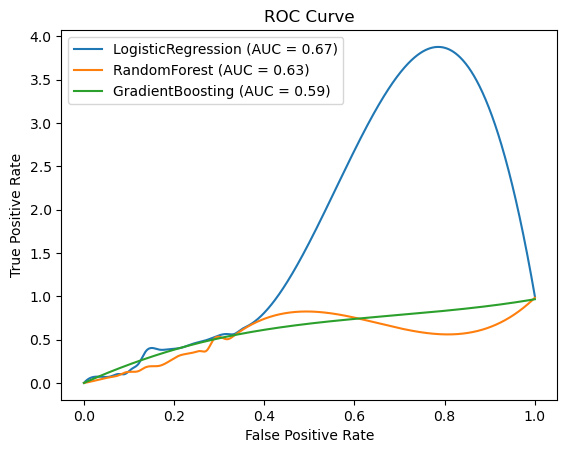

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.interpolate import CubicSpline
import numpy as np

for model_name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} AUROC: {auc}")
    
    # Plot ROC Curve with Cubic Spline Interpolation
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Ensure that FPR is strictly increasing (sort and remove duplicates)
    # If there are duplicate FPR values, we take the first corresponding TPR value
    sorted_indices = np.argsort(fpr)  # Sort indices based on FPR values
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    
    # Remove duplicates by keeping the first occurrence of each FPR value
    fpr_unique, indices = np.unique(fpr_sorted, return_index=True)
    tpr_unique = tpr_sorted[indices]

    # Use Cubic Spline interpolation for smoother curve
    spline = CubicSpline(fpr_unique, tpr_unique)
    
    # Create a finer set of FPR values for smoother plotting
    fpr_smooth = np.linspace(0, 1, 1000)
    tpr_smooth = spline(fpr_smooth)

    # Plot the smoothed ROC curve
    plt.plot(fpr_smooth, tpr_smooth, label=f'{model_name} (AUC = {auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()